# Descripción

[Pagina de buscaminas en el que se baso el algoritmo](https://www.solitar.io/buscaminas)

# Dependencias

Si no puedes correr el codigo, descomenta las siguientes lineas de codigo o ejecutalas directamente desde tu terminal y reinicia el kernel de python.

<strong>Nota</strong>: Al ejecutarse por primera vez el proyecto, se tardara unos minutos

In [1952]:
#pip install pyautogui opencv-python easyocr

In [1953]:
#pip install torch==2.3.1 torchaudio==2.3.1 torchvision==0.18.1

In [1954]:
#pip install -U matplotlib

In [1955]:
#pip install --upgrade easyocr

# Librerias

In [1957]:
import os
import cv2
import time
import easyocr
import logging
import pyautogui
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [1958]:
start_time = time.time()

# Captura de pantalla

In [1960]:
# Obtenemos la imagen de la captura de pantalla
def take_screenshot():
    screenshot = pyautogui.screenshot()
    return cv2.cvtColor(np.array(screenshot), cv2.COLOR_RGB2BGR)

# Obtenemos los colores presentes en el tablero
def get_colors():
    return np.array([
        [247, 236, 227], # White
        [158, 92, 21],   # Blue
        [200, 113, 27],  # Background
    ], dtype=np.uint8)

# Creamos las mascaras de los colores
def create_mask_colors(screenshot, colors):
    return [cv2.inRange(screenshot, color, color) for color in colors]

# Obtenemos los contornos de la imagen
def get_contours(masks):
    combined_mask = np.bitwise_or.reduce(masks)
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours

# Obtenemos las dimensiones de una imagen (x, y, width, height)
def get_dimensions(contours):
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    return x, y, w, h

In [1961]:
# Captura de pantalla
screenshot = take_screenshot()
colors = get_colors()
masks = create_mask_colors(screenshot, [colors[-1]])
colors = colors[:-1]

# Obtenemos la imagen de la tabla
table_contours = get_contours(masks)
table_dims = get_dimensions(table_contours)

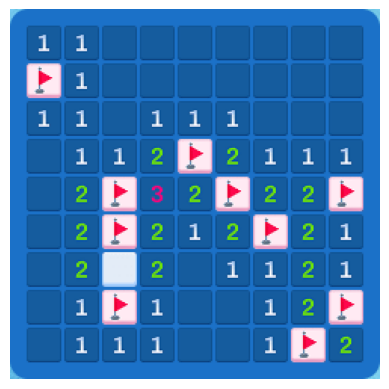

In [1962]:
x, y, w, h = table_dims
plt.imshow(cv2.cvtColor(screenshot[y:y+h, x:x+w], cv2.COLOR_BGR2RGB), cmap='gray')
plt.axis('off')  # Ocultar los ejes
plt.show()

In [1963]:
def get_squares(square_contours):
    squares = []
    for contour in square_contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / float(h)
        if 0.9 <= aspect_ratio <= 1.3:
            squares.append((x, y, w, h))

    return squares

def remove_numbers_with_distance(numbers_set, distance):
    sorted_numbers = sorted(numbers_set)
    
    i = 0
    while i < len(sorted_numbers) - 1:
        if sorted_numbers[i + 1] - sorted_numbers[i] <= distance:
            index = i if sorted_numbers[i + 1] < sorted_numbers[i] else (i + 1)
            numbers_set.remove(sorted_numbers[index])
            sorted_numbers = sorted(numbers_set)
        else:
            i += 1

    return sorted(numbers_set)

In [1964]:
# Obtenemos los colores
x, y, w, h = table_dims
square_masks = create_mask_colors(screenshot[y:y+h, x:x+w], colors)

# Colores de cuadrados
square_contours_white = get_contours([square_masks[0]]) # Cuadrado blanco
square_contours_blue = get_contours([square_masks[1]]) # Cuadrado azul

# Cuadrados
squares = get_squares(square_contours_white) + get_squares(square_contours_blue)
square_size = np.max(np.array(squares)[:, 2:].flatten())

x_coords = remove_numbers_with_distance(set(x for x, _, _, _ in squares), square_size)
y_coords = remove_numbers_with_distance(set(y for _, y, _, _ in squares), square_size)

In [1965]:
len(x_coords), len(y_coords)

(9, 9)

In [1966]:
square_coords = [[(x, y) for x in x_coords] for y in y_coords]

# Lectura del tablero

In [1968]:
# Modelo descifrador de texto
logging.getLogger().setLevel(logging.ERROR)
reader = easyocr.Reader(['en'])

In [1969]:
# Obtenemos la imagen de una casilla del tablero
def get_square(screenshot, table_dims, sx, sy, square_size):
    x, y, w, h = (
        table_dims[0] + sx, 
        table_dims[1] + sy, 
        square_size, 
        square_size
    )
    return screenshot[y:y+h, x:x+w]

# Redimensionamiento de la imagen
def scale_image(square, width, inter=cv2.INTER_AREA):
    original_height, original_width = square.shape[:2]
    if original_width == width:
        return square
    
    ratio = width / float(original_width)
    height = int(original_height * ratio)
    
    return cv2.resize(square, (width, height), interpolation=inter)

# Conversion de string a numero
def str_to_number(str_value):
    try:
        return int(str_value)
    except ValueError:
        return

# Desciframos el numero de la casilla    
def get_number(square):
    results = reader.readtext(square)
    if not results:
        return -1

    sorted_results = sorted(results, key=lambda x: x[2], reverse=True)
    return str_to_number(sorted_results[0][1])

# Obtenemos el valor de una casilla (revelada_con_numero: numero, oculta: 0, revelada_sin_numero: -1)
def get_cell_value(square, color):
    mask = cv2.inRange(square, color, color)
    color_percentage = (np.sum(mask) / (mask.size * 255)) * 100

    if color_percentage == 0:
        return 0

    return get_number(square)

In [1970]:
n, m = len(y_coords), len(x_coords)

<strong>NOTA:</strong> Si el tablero se esta leyendo mal, ajuste el siguiente valor

In [1972]:
SCALE_IMG = 80

In [1973]:
table = np.zeros((n, m))

for i in range(n):
    for j in range(m):
        sx, sy = square_coords[i][j]
        square = get_square(screenshot, table_dims, sx, sy, square_size)
        resized_square = scale_image(square, SCALE_IMG)
        table[i, j] = get_cell_value(resized_square, colors[1])

In [1974]:
# Mostramos el tablero
def show_table(table, precision=0):
    str_value = np.array2string(table, precision=precision, floatmode='fixed')
    str_value = " " + str_value.replace("[", "").replace("]", "")
    str_value = str_value.replace("." + "0" * precision, " " * (precision + 1))
    print(str_value)

En la siguiente celda se muestra el resultado de la lectura del tablero, si visualiza un número incorrecto o un <b>nan</b>, quiere decir que el tablero se leyó incorrectamente.

In [1976]:
show_table(table)

  1   1  -1  -1  -1  -1  -1  -1  -1 
  0   1  -1  -1  -1  -1  -1  -1  -1 
  1   1  -1   1   1   1  -1  -1  -1 
 -1   1   1   2   0   2   1   1   1 
 -1   2   0   3   2   0   2   2   0 
 -1   2   0   2   1   2   0   2   1 
 -1   2   0   2  -1   1   1   2   1 
 -1   1   0   1  -1  -1   1   2   0 
 -1   1   1   1  -1  -1   1   0   2 


# Calculo de heuristica

Para el calculo de la heuristica, se hace lo siguiente:  

- Se toma una celda, vacia y se forma un cuadrado en diagonal hacia ella, para revisar si es un caso especial, sino se halla la heuristica de forma normal

- Ejemplo de caso especial:  
    - Primero, se toma una celda vacia con celdas adyacentes con numeros y se forma un cuadrado en diagonal, asi:  
    
    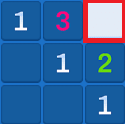  
    
    - Luego nos desplazamos a la celda numerica diagonal a la celda vacia:  
    
    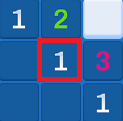  
    
    - Si el valor de la celda coincide con el numero de celdas vacias que tiene alrededor, entonces la celda vacia que evaluamos es una mina

- Ejemplo de caso general:
    - En caso de que no se haya encontrado un caso especial, se halla la heuristica con una celda vacia con celdas adyacentes numericas, asi:  
    
    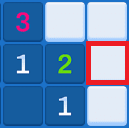  
    
    - A esa celda vacia buscamos sus celdas adyacentes con numeros y sumaremos sus valores (LLamemoslo M):  
    
    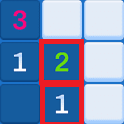
    
    - Ademas a esas celdas, contaremos las celdas vacias que tengan alrededor (Llamemoslo EC) y el numero de minas alrededor (MP):  
    
    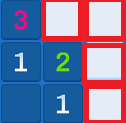
    
    - Si nos basamos del caso especial, la siguiente celda es una mina, por lo tanto, solo hay 3 celdas libres:  
    
    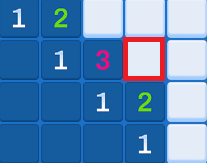

    - Finalmente, la heuristica se halla asi:  
    
    $H = \dfrac{M - MP}{EC} = \dfrac{3 - 1}{3} = \dfrac{2}{3} = 0.66$

    - Nota: Si EC es cero, entonces H es 1 si hay minas por colocar

In [1978]:
# Obtenemos el valor de una celda (-3 si no existe)
def get_cell(table, i, j):
    if 0 <= i < len(table) and 0 <= j < len(table[0]):
        return table[i][j]
    return -3

# Celdas adyacentes a una celda
def get_adjacent_cells(table, i, j):
    adjacent_cells = []
    
    for dx, dy in [(-1, -1), (0, -1), (1, -1), (1, 0), (1, 1), (0, 1), (-1, 1), (-1, 0)]:
        ni, nj = i + dy, j + dx
        cell_value = get_cell(table, ni, nj)
        
        if cell_value != -3:
            adjacent_cells.append((ni, nj, cell_value))
    
    return adjacent_cells

# Celdas con numeros
def adjacent_cell_with_positive_numbers(table, i, j):
    return [(ni, nj, cell_value) for ni, nj, cell_value in get_adjacent_cells(table, i, j) if cell_value > 0]

# Numero de celdas con numeros
def num_adjacent_cell_with_positive_numbers(table, i, j):
    return sum(1 for _, _, cell_value in get_adjacent_cells(table, i, j) if cell_value > 0)

# Minas alrededor de una celda
def mines_around_cell(table, i, j):
    return sum(1 for _, _, cell_value in get_adjacent_cells(table, i, j) if cell_value == -2)

# Celdas vacias alrededor de una celda
def empty_cells_around(table, i, j):
    return {(ni, nj) for ni, nj, cell_value in get_adjacent_cells(table, i, j) if cell_value == 0}

# Caso en el que se presenta una esquina
# Ejemplo:
# [-1] [-1] [-1]
# [-1]  [1]  [2]
# [-1]  [2]  [x]
# x es la celda a evaluar
def is_special_case(table, i, j):
    cases = [
        [ # Arriba-Derecha
            (0, -1), (1, 0), # Adyacentes con numeros
            (1, -1) # Diagonal con un numero
        ],
        [ # Derecha-Abajo
            (1, 0), (0, 1), # Adyacentes con numeros
            (1, 1) # Diagonal con un numero
        ],
        [ # Abajo-Izquierda
            (0, 1), (-1, 0), # Adyacentes con numeros
            (-1, 1) # Diagonal con un numero
        ],
        [ # Izquierda-Arriba
            (-1, 0), (0, -1), # Adyacentes con numeros
            (-1, -1) # Diagonal con un numero
        ]
    ]

    if get_cell(table, i, j) == 0: # Si es una celda oculta
        for case in cases:
            is_numbers = all(get_cell(table, i + dy, j + dx) > 0 for dx, dy in case) # Rodeada por 3 celdas con numeros
            
            dx, dy = case[-1]
            ni, nj = i + dy, j + dx
            num_empties = len(empty_cells_around(table, ni, nj))
            cell_value = get_cell(table, ni, nj)
            mines_around = mines_around_cell(table, ni, nj)

            # Si las celdas vacias es igual a las minas restantes para que la celda tenga el numero indicado de minas alrededor
            if num_empties == cell_value - mines_around and is_numbers:
                return True

    return False

# Validacion del tablero
def is_valid_board(table, full=False):
    for i in range(len(table)):
        for j in range(len(table[i])):
            cell_value = get_cell(table, i, j)
            mines_around = mines_around_cell(table, i, j)

            # El tablero es valido solo:
            # 1. Si esta lleno y todas las celdas numericas tienen el mismo numero de minas alrededor que lo que indica su valor
            # 2. Si no esta lleno y hay alguna celda numerica con un menor numero de minas alrededor que lo que indica su valor
            cond = (cell_value < mines_around) or (mines_around < cell_value and full)
            
            if cell_value > 0 and cond:
                return False
    return True

# Se pone el caso especial en el tablero y se evalua si es valido o no
def is_valid_special_case(table, i, j):
    if is_special_case(table, i, j):
        new_table = [row.copy() for row in table]
        new_table[i][j] = -2
        return is_valid_board(new_table)
    return False

# Calculo de la heuristica
def heuristic(table, i, j):
    mines_around, empty_cells = 0, set()
    adjacent_cells = adjacent_cell_with_positive_numbers(table, i, j)

    # Si es un caso especial, la heuristica es el mayor numero posible
    if is_valid_special_case(table, i, j):
        return 100
    
    # Si la celda no es oculta o si no tiene celdas adyacentes
    if not adjacent_cells or get_cell(table, i, j) != 0:
        return 0

    # Calculo de minas y celdas vacias alrededor
    for ni, nj, cell_value in adjacent_cells:
        mines_around += cell_value - mines_around_cell(table, ni, nj)
        empty_cells.update(empty_cells_around(table, ni, nj))
        
    return mines_around / len(empty_cells) if empty_cells else int(mines_around > 0)

# Algoritmo para resolver el buscaminas

La logica del algoritmo es encontrar las posibilidades (se limitan) de posicionar las minas en el tablero y que sea valido, luego con esas posibilidades se halla una probabilidad.

El algoritmo hace lo siguiente:
1. Calcula la heuristica de las celdas de la tabla que cumplan la condicion para ser calculadas
2. De esas heuristicas se eliminan los movimientos invalidos  
    - Un movimiento es invalido si se intento colocar una mina, pero al colocarse rompe las reglas de buscaminas
3. Primeramente, se revisa si se puede continuar poniendo minas en el tablero (si alguna celda numerica le falta una mina alrededor) o si tengo heuristicas a evaluar
    - Si no es posible continuar, se revisa si el tablero que se formo es valido
    - Si el tablero es valido, se guarda esa posibilidad, sino nos devolvemos
4. De esas heuristicas restantes se obtiene la mayor heuristica
    - Si el valor de esa heuristica es 100 (caso especial), entonces se descartan las demas heuristicas
5. Se crea un nuevo tablero con ese movimiento
    - Si ese tablero ya fue visitado nos devolvemos, sino se añade a los tableros ya visitidos y continuamos
6. Se revisa si el movimiento es valido
    - Si ese movimiento es valido en el tablero, se vuelven a calcular las heuristicas y se sigue con el algoritmo
    - Si no es valido, se añade como movimiento invalido para las iteraciones hermanas
7. Se siguen revisando posibilidades quitando el movimiento anterior, pero con las mismas heuristicas
8. El algoritmo termina cuando se haya alcanzado el numero maximo de posibilidades o no haya más heuristicas que evaluar
9. Con los tableros obtenidos se halla la probabilidad de que haya una mina en las posiciones y se devuelve el movimiento con menor probabilidad
10. si hay mas de un movimiento, entonces se busca aquel en el que la resta de M (suma de los valores de las celdas adyacentes con numeros) menos MP (Minas posicionadas) sea mayor.

<strong>NOTA:</strong>
1. El tablero es valido solo
    - El tablero es valido solo si esta lleno y todas las celdas numericas tienen el mismo numero de minas alrededor que lo que indica su valor
    - Si no esta lleno y hay alguna celda numerica con un menor numero de minas alrededor que lo que indica su valor
2. Cuanto mayor se el maximo de posibilidades permitido, mejor sera el movimiento que dara como que no es mina, pero se tardara más en el algoritmo.

In [1980]:
# Calculo de la heuristica para hallar donde se ubica una mina
def calculate_heuristics(table):
    heuristics = []
    for i in range(len(table)):
        for j in range(len(table[i])):
            value = heuristic(table, i, j)
            if value > 0: # La celda es valida para evaluar
                heuristics.append((i, j, value))
    return sorted(heuristics, key=lambda x: x[2])

# Se puede continuar colocando minas
def can_continue(table):
    for i in range(len(table)):
        for j in range(len(table[i])):
            cell = get_cell(table, i, j)
            # Se pueden colocar minas si hay alguna celda con numero con menos minas alrededor
            if 0 < cell and mines_around_cell(table, i, j) < cell:
                return True
    return False

# Se toman todas las posibilidades de colocar minas en el tablero y se halla la probabilidad de cada posicion
def calculate_probability(matrices, target_number, row_index, col_index):
    total_matrices = len(matrices)
    count = sum(matrix[row_index][col_index] == target_number for matrix in matrices)
    return 0 if total_matrices == 0 else (count / total_matrices), count

# Se llena una matriz con las probabilidades de que una celda sea una mina
def get_probabilities(table, paths, n, m):
    prob_table = np.ones((n, m))
    
    for i in range(n):
        for j in range(m):
            prob, count = calculate_probability(paths, -2, i, j)
            num_adj = num_adjacent_cell_with_positive_numbers(table, i, j)
            cell = get_cell(table, i, j)
            
            if 0 < count or (cell == 0 and 0 < num_adj):
                prob_table[i, j] = prob
            else:
                prob_table[i, j] = 2
                
    return prob_table

# Se elije la celda con menor posibilidad de ser mina
def choose_movement(table, prob_table):
    # Se busca la que tenga el menor valor de la resta entre la suma de valores de celdas numericas adyacentes y las minas posicionadas
    def criterion(position):
        ni, nj = position
        mines = mines_around_cell(table_with_mines, i, j)
        total = sum(cell_value for _, _, cell_value in adjacent_cell_with_positive_numbers(table_with_mines, ni, nj))
        return total - mines + 100 * int(mines == 0) # deber haber por lo menos una mina

    # Se busca la menor probabilidad
    i, j = np.unravel_index(np.argmin(prob_table), prob_table.shape)
    indexes = np.where(prob_table == prob_table[i, j])

    # creamos el tablero para hallar la heuristica
    table_with_mines = np.array(table).copy()
    mine_indexes = np.where((0.5 <= prob_table) & (prob_table <= 1))
    table_with_mines[mine_indexes] = -2

    # Si hay mas de una celda con la misma posibilidad, se busca la menor heuristica
    heuristics = np.array([heuristic(table_with_mines, ni, nj) for ni, nj in zip(indexes[0], indexes[1])])
    heuristics_indexes = np.where(heuristics == np.min(heuristics))[0]

    # Si hay mas de una celda con la misma heuristica, se halla el menor valor, según un criterio
    return sorted([(indexes[0][hi], indexes[1][hi]) for hi in heuristics_indexes], key=criterion)[0]

# Se encuentra la posicion (i, j) de la celda con menos probabilidad de que sea una mina
def find_best_movement(table, valid_paths):
    print(len(valid_paths))
    prob_table = get_probabilities(table, valid_paths, len(table), len(table[0]))
    show_table(prob_table, precision=1)
    return choose_movement(table, prob_table)

# Algoritmo para resolver el buscaminas
def minesweeper_solver(table, heuristics_list, valid_paths, max_possibilities, visited_tables=set(), invalid_movements=[]):
    # Si se pasa el numero de posibilidades
    if len(valid_paths) >= max_possibilities:
        return
    
    heuristics_list = [heur for heur in heuristics_list if (heur[0], heur[1]) not in invalid_movements]
    
    # Si no se puede continuar o no hay mas movimientos
    if not can_continue(table) or not heuristics_list:
        if is_valid_board(table, full=True): # Si el tablero es valido, se añade la posibilidad
            valid_paths.append(table)
        return
    
    i, j, h = heuristics_list.pop() # Se obtiene la posicion (i, j) con la mayor heuristica
    if h == 100: # Si es un caso especial, se descartan las demas posibilidades
        heuristics_list.clear()
    
    # Se crea un nuevo tablero
    new_table = [row.copy() for row in table]
    new_table[i][j] = -2 # Se asume que la posicion (i, j) es mina
    
    # Si un tablero se repite, no se sigue
    table_tuple = tuple(tuple(row) for row in new_table)
    if table_tuple in visited_tables:
        return
    
    visited_tables.add(table_tuple)
    new_invalid_movements = invalid_movements.copy()
    
    # Se valida si la posicion (i, j) es mina
    if is_valid_board(new_table): # Si es correcto, se continua
        new_heuristics = calculate_heuristics(new_table)
        minesweeper_solver(new_table, new_heuristics, valid_paths, max_possibilities, visited_tables, new_invalid_movements)
    
    else: # Sino, se añade como movimiento invalido
        new_invalid_movements.append((i, j))

    # Se añaden los invalidos
    for i, j, _ in heuristics_list:
        temp_table = [row.copy() for row in table]
        temp_table[i][j] = -2
        table_tuple = tuple(tuple(row) for row in temp_table)
        
        if not is_valid_board(temp_table):
            new_invalid_movements.append((i, j))
            visited_tables.add(table_tuple)
    
    # Se intenta con los movimientos restantes
    minesweeper_solver(table, heuristics_list, valid_paths, max_possibilities, visited_tables, new_invalid_movements)

# Solución

In [1982]:
valid_paths = []
MAX_POSSIBILITIES = 1

In [1983]:
heuristics_list = calculate_heuristics(table)
minesweeper_solver(table, heuristics_list, valid_paths, MAX_POSSIBILITIES)

La siguiente celda imprime las posibilidades validas que encontró el algoritmo para posicionar las minas y las probabilidades de que una celda sea una mina.

<b>Nota:</b>  
- Si se imprime un cero en la siguiente celda, quiere decir que el tablero posiblemente se leyó mal.
- Si <strong>MAX_POSSIBILITIES</strong> es 1, el calculo solo se baso en la heuristica, si es mayor a 1, entonces el calculo se baso en las posibilidades de tablero que generó la heuristica.

In [1985]:
square_i, square_j = find_best_movement(table, valid_paths)

1
 2   2   2   2   2   2   2   2   2  
 1   2   2   2   2   2   2   2   2  
 2   2   2   2   2   2   2   2   2  
 2   2   2   2   1   2   2   2   2  
 2   2   1   2   2   1   2   2   1  
 2   2   1   2   2   2   1   2   2  
 2   2   0   2   2   2   2   2   2  
 2   2   1   2   2   2   2   2   1  
 2   2   2   2   2   2   2   1   2  


In [1986]:
# Se muestra el mejor movimiento
def show_best_movement(table_dims, i, j, square_size):
    x, y, w, h = table_dims
    sx, sy = square_coords[i][j]
    
    table = screenshot[y:y+h, x:x+w]    
    cv2.rectangle(table, (sx, sy), (sx+square_size, sy+square_size), (0, 0, 0), 2)

    plt.imshow(cv2.cvtColor(table, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.axis('off')  # Ocultar los ejes
    plt.show()

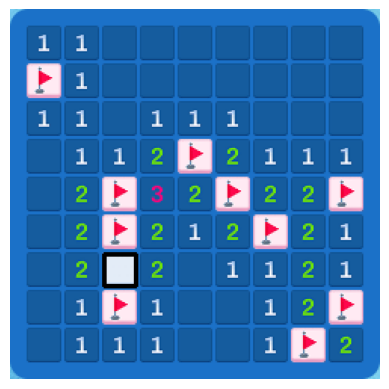

In [1987]:
show_best_movement(table_dims, square_i, square_j, square_size)

# Tiempo transcurrido

In [1989]:
end_time = time.time()

In [1990]:
elapsed_time = end_time - start_time

minutes = int(elapsed_time // 60)
seconds = int(elapsed_time % 60)

print(f"{minutes}min {seconds}s")

0min 18s


# Referencias
- “How to Write your own Minesweeper AI”. Lucky's Notes. [En línea]. Disponible: https://luckytoilet.wordpress.com/2012/12/23/2125/
- “¿Cómo ganar al Buscaminas?: Inteligencia artificial con casi 100% de probabilidad de éxito (vídeo) – NeoTeo”. NeoTeo – Tecnología, todos los días. Software, hardware, ciencia y videojuegos. [En línea]. Disponible: https://www.neoteo.com/como-ganar-al-buscaminas-inteligencia-artificial-con-100-de-probabilidad-de-exito-video/